<a href="https://colab.research.google.com/github/OlenaBugaiova/collecting-data-about-norwegian-agriculture/blob/main/Agriculture_Text_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

Visualize text data collected from norwegian websites on agriculture:



*   https://www.nibio.no
*   https://www.plantevernleksikonet.no/
*   https://www.nlr.no/fagartikler



In [ ]:
NIBIO_TEXT_FILE_URL = 'nibio_text_data.json'
PLANTEVERNLEKSIKONET_TEXT_FILE_URL = 'plantevernleksikonet_text_data.json'
OM_NORSK_LANDBRUKS_RADGIVING_URL = 'nlr_text_data.json'

# Import Libraries

In [ ]:
!pip install nltk

In [ ]:
from google.colab import files
import io

import json

# libraries for text processing
import re
import string
import pprint

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder

from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
RANDOM_STATE = 311

# Methods for Data Preprocessing and Visualization

In [ ]:
def upload_text_file(file_name):

    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))


    text_file = open(file_name)
    text_file_content = text_file.read()

    text_file_content_json = json.loads(text_file_content)

    return text_file_content_json

When we combine text from different paragraphs together we can have etra new line symbols, tabs or dots. We want to clean up them

In [ ]:
def tidy_up_new_line_symbols(article):

    # we will remove tab symbol and keep only new line symbol
    # when a new line symbol occurs more than once consecutively
    # we replace it with only one

    article = article.replace('\t', '\n')

    while '\n\n' in article:
        article = article.replace('\n\n', '\n')

    while '\n \n' in article:
        article = article.replace('\n \n', '\n')

    article = article.replace('\n', '\n ')

    return article

def tidy_up_dots(article):

    # ensure that each article ends with a dot
    # when a dot symbol occurs more than once consecutively
    # we replace it with only one

    article = article + '.'

    while '..' in article:
        article = article.replace('..', '.')

    while '?.' in article:
        article = article.replace('?.', '.')

    return article

def tidy_up_punctuation(text: dict):

    titles = text.keys()

    for title in titles:

        article = text[title]
        article = tidy_up_new_line_symbols(article)
        article = tidy_up_dots(article)

        text[title] = article
    return text

Text preview

In [ ]:
def preview_text(text_dict):

    text_df = pd.DataFrame(text_dict.items(), columns = ['Title', 'Article'])
    display(text_df.head(5))

Remove stop words, punctuation, numbers, single sybmol words from the vocabulary. Not all stop words were included into norwegian language. That's why we remove stop words found in our text as they occur often but don't bring much of information

In [ ]:
def clean_text_data(vocabulary):

    stop_words = stopwords.words('norwegian')

    stop_words_extended = [
        'ei', 'et', 'en', 'under', 'over', 'da', 'bak', 'foran', 'ved', 'mot',
        'til', 'for', 'siden', 'av', 'ned', 'opp', 'to', 'andre', 'mer',
        'litt', 'flere', 'må', 'ofte', 'mye', 'god', 'godt', 'stor',
        'store', 'ca', 'mindre', 'hos', 'mest', 'nye', 'ny', 'derfor', 'ulike',
        'gjennom', 'større', 'dersom', 'hele', 'arter', 'første', 'lange',
        'lite', 'per', 'mens', 'lang', 'rundt', 'nok', 'lett', 'kg', 'først',
        'fleste', 'eng', 'bedre', 'gode', 'pr', 'best', 'hvert', 'siste',
        'langs', 'igjen', 'nlr', 'like', 'helt', 'annet', 'prosent', 'stort',
        'langt', 'dårlig', 'meir', 'størst', 'alt', 'ikke', 'det', 'e', 'pa',
        'de', 'den', 'ma', 'v', 't', 'g', 'se', 's', 'f', 'brun', 'svart', 'ga',
        'h', 'o', 'en', 'd', 'al', 'sa', 'gra', 'rød', 'grå', 'daa',
        'danne', 'eller', 'svært', 'lid'
        ]
    stop_words.extend(stop_words_extended)

    # remove punctuation
    filtered_vocabulary = [
        word for word in vocabulary if word not in string.punctuation
    ]

    # remove leading special characters from words
    filtered_vocabulary = [re.sub(r'^\W+', '', w) for w in filtered_vocabulary]

    # remove numbers and arithmetic expressions
    pattern_numbers_and_expressions = re.compile('^(([-+/*,.])+)?\d+')

    filtered_vocabulary =[
        word for word in filtered_vocabulary if not (
            pattern_numbers_and_expressions.match(word)
        )
    ]

    # remove stop words
    words_to_remove = stop_words
    filtered_vocabulary = [
        word for word in filtered_vocabulary if word not in words_to_remove
    ]

    # remove words with only one symbol
    filtered_vocabulary = list(filter(
        lambda x: (len(x) > 1), filtered_vocabulary
    ))

    return filtered_vocabulary

Quantitative characteristics of the text

In [ ]:
def describe_text_quantitatively(text_dict):

    print(f'Number of articles: {len(text_dict)}\n')

    articles = text_dict.values()

    full_text = ' '.join(articles).lower()

    sentences_all = nltk.sent_tokenize(full_text)

    # don't count one word sentences
    sentences = [sentence for sentence in sentences_all if len(sentence) > 1]
    print(f'Number of sentences in the text: {len(sentences)}\n')

    tokens = nltk.word_tokenize(' '.join(sentences_all))
    print(f'Number of tokens in the text: {len(tokens)}\n')

    vocabulary = sorted(set(tokens))
    vocabulary = clean_text_data(vocabulary)
    print(f'Size of the text vocabulary: {len(vocabulary)}\n')

    return tokens, vocabulary

In [ ]:
def clean_tokens(vocabulary, tokens):

    cleaned_tokens = [token for token in tokens if token in vocabulary]
    return cleaned_tokens

In [ ]:
def plot_frequency_tokens(tokens):

    word_freq = nltk.FreqDist(tokens)
    # print(*list(word_freq)[:200], sep = '\n')

    plt.figure(figsize = (17, 3))
    word_freq.plot(60, title = 'The most frequent words in text')

    return word_freq

In [ ]:
def plot_word_cloud(word_freq):

    # The wordcloud
    plt.figure(figsize = (10, 8))
    wc = WordCloud(background_color = 'white', colormap = 'YlGnBu', max_words = 100, max_font_size = 60,  width = 500, height = 250)
    wc.generate(' '.join(word_freq))
    plt.imshow(wc.recolor( colormap = 'Spectral' , random_state = RANDOM_STATE), alpha = 0.98, interpolation = 'bilinear', )
    plt.axis('off')

Plot collocations. A collocation is a series of words or terms that co-occur more often than would be expected by chance.

In [ ]:
def get_bigram_collocations(tokens):
    bigram_frequency_creteria = 10
    max_number_allocations = 1000

    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(bigram_frequency_creteria)

    bigram_collocation = finder.nbest(bigram_measures.likelihood_ratio, max_number_allocations)
    bigram_collocation = [' '.join(col) for col in bigram_collocation]

    return bigram_collocation

In [ ]:
def get_trigram_collocations(tokens):
    trigram_frequency_creteria = 5
    max_number_allocations = 500

    trigram_measures = TrigramAssocMeasures()

    finder = TrigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(trigram_frequency_creteria)

    trigram_collocation = finder.nbest(trigram_measures.likelihood_ratio, max_number_allocations)
    trigram_collocation = [' '.join(col) for col in trigram_collocation]

    return trigram_collocation

In [ ]:
def display_the_most_frequent_word_items(tokens, bigrams, trigrams, top_n):

    freq_df = pd.DataFrame(
    {
        'words': tokens[:top_n],
        'bigrams': bigrams[:top_n],
        'trigrams': trigrams[:top_n]
    })

    print(f'{top_n} the most used items in text:')
    display(freq_df)

# Nibio

Upload text data

In [ ]:
nibio_text_file_content_json = upload_text_file(NIBIO_TEXT_FILE_URL)

Saving nibio_text_data.json to nibio_text_data.json
User uploaded file "nibio_text_data.json" with length 989136 bytes


In [ ]:
# print(json.dumps(nibio_text_file_content_json, ensure_ascii = False, indent = 4))

Reorganize text in a form of dictionary with titles and articles:

In [ ]:
nibio_text_file_content = {}

sections = nibio_text_file_content_json

while len(sections) > 0:

    section = sections.pop(0)
    title = section['title']
    article = section['text']
    nibio_text_file_content[title] = article

    if 'children' in section:
        sections.extend(section['children'])

In [ ]:
nibio_text_file_content = tidy_up_punctuation(nibio_text_file_content)

Text preview

In [ ]:
preview_text(nibio_text_file_content)

,Title,Article
0,Skog,"Hvor mye skog er det i Norge og hvordan kan vi best utnytte og ta vare på den? Hvordan påvirker skogen klimaet? Ved NIBIO har vi oversikt over skogressursene og skogens vekst og utvikling i Norge. Vi forsker på effektiv skogskjøtsel og -drift, bruk av tre og karbonlagring. Vi overvåker forekomst av skader på skogen."
1,Jord,"Hvor er den beste matjorda? Hva består jorda av og hvordan fungerer den? Hvor og hvordan er landbruksarealene fordelt? NIBIO kartlegger hva slags jordressurser vi har, hvor de er og hvilke egenskaper jorda har. Vi overvåker også hvor store lagrene er og endringer i jordkarbon i skog og beite."
2,Mat,"Hvordan kan vi produsere nok mat til alle, uten å forurense miljøet og drikkevannet, og uten å bidra til at klimaendringene blir verre? NIBIO forsker på hvilke plantesorter som produserer mest mat, og hvordan maten bør dyrkes. Ny teknologi gjør det mulig å produsere mer mat på en miljøvennlig måte."
3,Plantehelse,"Hvorfor blir planter sjuke? NIBIO overvåker plantesjukdommer, skadedyr og ugras, studerer hvorfor skader på planter oppstår, og hvordan vi kan holde planter friske. Vi analyserer også rester av plantevernmidler og ulike andre stoffer i planter."
4,Landskap,"I NIBIO forsker vi på landskap som mennesker har påvirket med jord- og skogbruk. Slike landskap finnes i lavlandet og på fjellet, i daler og langs fjorder, landlig og bynært. Vi kartlegger og overvåker bruk av arealer, biologisk mangfold og kulturminner."


This is high level brief description of the topics, later articles contain more text

Quantitative characteristics

In [ ]:
tokens, vocabulary = describe_text_quantitatively(nibio_text_file_content)

Number of articles: 497

Number of sentences in the text: 6970

Number of tokens in the text: 144511

Size of the text vocabulary: 16330



# Plantevernleksikonet

Upload text data

In [ ]:
plantevernleksikonet_text_file_content_json = upload_text_file(PLANTEVERNLEKSIKONET_TEXT_FILE_URL)

Saving plantevernleksikonet_text_data.json to plantevernleksikonet_text_data.json
User uploaded file "plantevernleksikonet_text_data.json" with length 3297081 bytes


In [ ]:
# print(json.dumps(
#     plantevernleksikonet_text_file_content_json,
#     ensure_ascii = False,
#     indent = 4
#     ))

Reorganize text in a form of dictionary with titles and articles

We want to keep information from headers about latin name and group in additional text file

In [ ]:
plantevernleksikonet_text_file_content = {}
plantevernleksikonet_text_file_content_with_headers = {}

for title in plantevernleksikonet_text_file_content_json.keys():

    article_info = plantevernleksikonet_text_file_content_json[title]

    headers = article_info['headers'].split('\n')
    headers_text = ''

    if len(headers) > 1:
        headers_text = 'Name in latin: ' + headers[1].lower() + '. '

        if len(headers) > 2:
            headers_group = 'Group: ' + headers[2].lower() + '. '
            headers_text = headers_text + headers_group

    article_text = ' '.join([
        article_info['summary'], article_info['content'
        ]])
    article_text_with_headers = ' '.join([
        headers_text, article_info['summary'], article_info['content']
        ])

    plantevernleksikonet_text_file_content[title] = article_text
    plantevernleksikonet_text_file_content_with_headers[title] = article_text_with_headers

In [ ]:
plantevernleksikonet_text_file_content = tidy_up_punctuation(
    plantevernleksikonet_text_file_content
    )

plantevernleksikonet_text_file_content_with_headers = tidy_up_punctuation(
    plantevernleksikonet_text_file_content_with_headers
    )

Text preview

In [ ]:
preview_text(plantevernleksikonet_text_file_content)

Title  \
0        Hestehov   
1   Bomullsmellus   
2  Veksthusmellus   
3          Mellus   
4         Bladlus   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Quantitative characteristics

In [ ]:
tokens, vocabulary = describe_text_quantitatively(plantevernleksikonet_text_file_content)

Number of articles: 1090

Number of sentences in the text: 33928

Number of tokens in the text: 525705

Size of the text vocabulary: 27092



# NLR

Upload text data

In [ ]:
nlr_text_file_content_json = upload_text_file(OM_NORSK_LANDBRUKS_RADGIVING_URL)

Saving nlr_text_data.json to nlr_text_data.json
User uploaded file "nlr_text_data.json" with length 2909637 bytes


In [ ]:
# print(json.dumps(
#     nlr_text_file_content_json,
#     ensure_ascii = False,
#     indent = 4
#     ))

In [ ]:
nlr_text_file_content = tidy_up_punctuation(
    nlr_text_file_content_json
    )

Text preview

In [ ]:
preview_text(nlr_text_file_content)

Title  \
0  Fossilfri maskinpark – muligheter for landbruket og status   
1       Strømproduksjon fra husdyrgjødsel – enkel betraktning   
2                   Høgaktuelt med energiproduksjon på garden   
3                                       Bioenergi er lønnsomt   
4                                 Garden som energiprodusent?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Quantitative characteristics

In [ ]:
tokens, vocabulary = describe_text_quantitatively(nlr_text_file_content)

Number of articles: 707

Number of sentences in the text: 28099

Number of tokens in the text: 508016

Size of the text vocabulary: 35127



# Text combined from 3 websites on agriculture

We want to check if the same title appears on different websites. In that case we want to combine text from different sources

In [ ]:
def combine_text(nibio_text, plantevernleksikonet_text, nlr_text):

    all_titles = (
        set(nibio_text.keys()) |
        set(plantevernleksikonet_text.keys()) |
        set(nlr_text.keys())
    )

    for title in all_titles:
        if title in nibio_text and title in plantevernleksikonet_text:

            text_under_title = ' '.join([nibio_text[title], plantevernleksikonet_text[title]])
            nibio_text[title] = text_under_title
            plantevernleksikonet_text[title] = text_under_title

        if title in nibio_text and title in nlr_text:

            text_under_title = ' '.join([nibio_text[title], nlr_text[title]])
            nibio_text[title] = text_under_title
            nlr_text[title] = text_under_title

        if title in plantevernleksikonet_text and title in nlr_text:

            text_under_title = ' '.join([plantevernleksikonet_text[title], nlr_text[title]])
            plantevernleksikonet_text[title] = text_under_title
            nlr_text[title] = text_under_title

    text_combined = nlr_text_file_content | plantevernleksikonet_text_file_content | nibio_text_file_content
    return text_combined


In [ ]:
text_combined = combine_text(
    nibio_text_file_content,
    plantevernleksikonet_text_file_content,
    nlr_text_file_content
    )

# Quantitative characteristics

In [ ]:
tokens, vocabulary = describe_text_quantitatively(text_combined)

Number of articles: 2292

Number of sentences in the text: 71147

Number of tokens in the text: 1190123

Size of the text vocabulary: 61906



# Visualizations

In [ ]:
cleaned_tokens = clean_tokens(vocabulary, tokens)

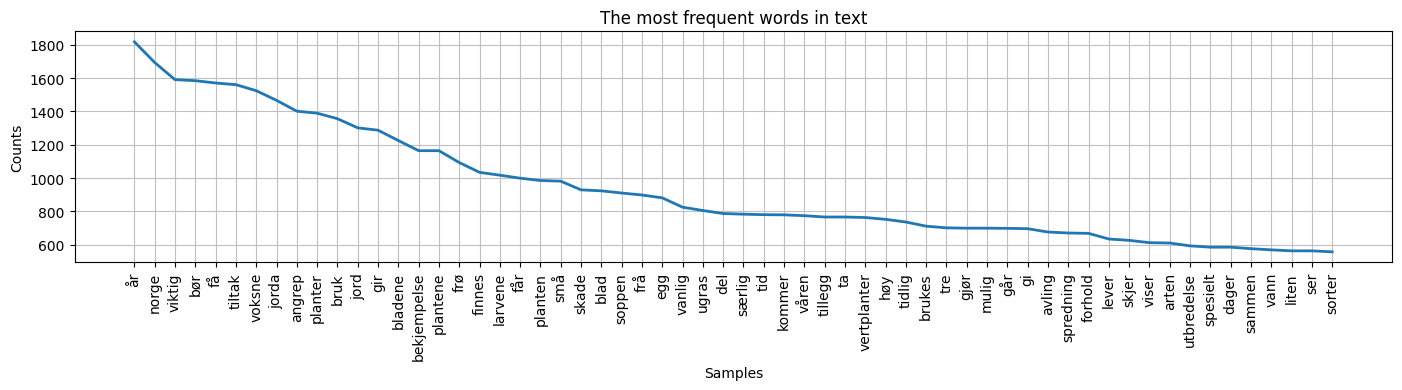

In [ ]:
tokens_freq = plot_frequency_tokens(cleaned_tokens)

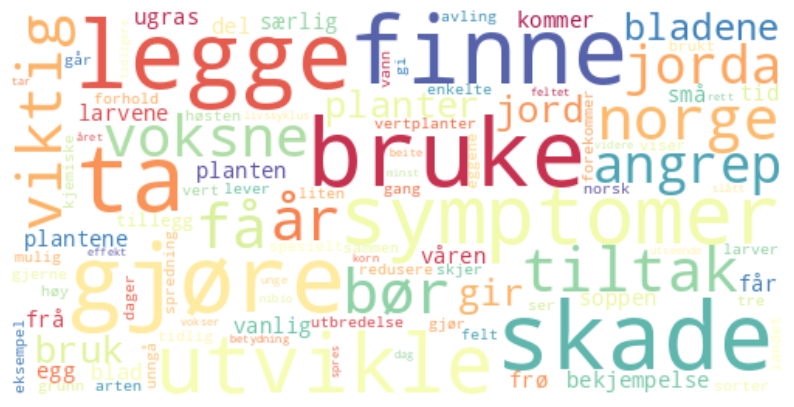

In [ ]:
plot_word_cloud(list(tokens_freq)[:500])

In [ ]:
bigram_collocations = get_bigram_collocations(cleaned_tokens)

In [ ]:
trigram_collocations = get_trigram_collocations(cleaned_tokens)

In [ ]:
display_the_most_frequent_word_items(
    list(tokens_freq),
    bigram_collocations,
    trigram_collocations,
    top_n = 30
    )

30 the most used items in text:


,words,bigrams,trigrams
0,år,formeringen spredningen,formeringen spredningen skjer
1,norge,opptrer ugras,voksne planten høy
2,viktig,overlevelse spredning,biologi formeringen spredningen
3,bør,sterke angrep,skade/ulempe opptrer ugras
4,få,spredningen skjer,kjennetegn voksne planten
5,tiltak,planten høy,hører biologiske gruppen
6,voksne,voksne planten,opptrer ugras hager
7,jorda,biologiske gruppen,spredningen skjer utelukkende
8,angrep,organisk materiale,opptrer ugras beite
9,planter,forebyggende tiltak,opptrer ugras slags


# Text Cleaning

Our text has references to images, for example (fig. 1) We want to remove it

In [ ]:
def remove_figure_from_text(text: dict):

    titles = text.keys()

    for title in titles:

        article = text[title]
        article = re.sub('\(fig.*?\)', '', article)
        article = re.sub('\(Fig.*?\)', '', article)

        text[title] = article
    return text

In [ ]:
text_combined = remove_figure_from_text(text_combined)

# Text Validation

We select articles randomly from the text file, and print title, text and a website from which this article was extracted. Then we search for the article on the website and compare extracted text with the text on the website

In [ ]:
# number of selected articles to verify
n = 3

In [ ]:
websites = {
    'nibio': nibio_text_file_content,
    'plantevernleksikonet': plantevernleksikonet_text_file_content,
    'nlr': nlr_text_file_content
}

In [ ]:
rng = np.random.default_rng()
selected_titles = rng.choice(list(text_combined.keys()), n, replace = False)

In [ ]:
print(*selected_titles, sep = '\n')

Når blir 2. slåtten?
Selen - livsviktig for dyrene dine
Colomba - riktig strategi for høyere tørrstoff


In [ ]:
def print_text_article(title):
    print(title)

    for website, website_text in websites.items():
        if title in website_text:
            print(f'website: {website}')
    print(text_combined[title])
    print('\n__________________________________________\n')


for title in selected_titles:
    print_text_article(title)

Når blir 2. slåtten?
website: nlr
Det er for tiden et utfordrende vær for alle som driver innen landbruket. Vi har hatt godt vær og dårlig vær i jevn blanding. Dette har gitt utfordrende høsteforhold. Langtidsvarslet viser at det vil være mye nedbør den neste perioden. For mange går dette bra, men for de som ikke er ferdig med slåtten er dette dårlig nytt. Videre skaper dette våte været utfordringer med å spre ut husdyrgjødsel. Jorda er vassmetta, og kjøring med utstyr på jorda gir store problemer med kjøreskader.
  Slåtten er tatt over mange uker. De tidligste startet med slåtten rundt 7. juni. Da hadde vi en liten periode med fint vær. Etter den tid var det ustabilt vær og mye nedbør i lengre tid. I månedsskiftet juni og juli hadde vi skikkelig høysommer, men det var ikke nok til at alle fikk tatt slåtten. Fortsatt gjenstår det eng som ikke er høstet. For enkelte områder gir dette gras med dårlig kvalitet. 
  Slåttestrategi den enkelte velger vil være en viktig faktor for hvor i arbe

In [ ]:
title = 'Marikåpe'
print_text_article(title)

Marikåpe
website: plantevernleksikonet
Vanlig marikåpe hører til den biologiske gruppen flerårig stedbundet med rotstokk. Den voksne planten er 10-20 cm høy. Den fullt utviklete rotstokken er ofte skråttstilt, mørkebrun, skjellet og har kraftige birøtter. Stengelen er lavtvoksende, ved grunnen nedliggende og oppstigende. De grunnstilte bladene er langstilkete, nyreformete, rundtakkete, med dypt innskårne og avrundete, sagtakkete avsnitt. Stengelbladene er mindre, og halvt stengelomfattende. De uanselige blomstene er tvekjønnete med 4 støvbærere og støvvei med én griffel som går ut fra fruktknuten, og de er kronbladløse. Vanlig marikåpe forekommer på eng og beitemark, i skogkanter, og på veikanter og jernbaneområder. De opptrer som ugras i eng og beite. Det sikreste mottiltaket er god og kraftig engkultur, med forutgående god jordarbeiding. De kan også bekjempes kjemisk med fenoksysyrer. Forveksling
 Andre arter i marikåpeslekten.
  Kjennetegn
  Den voksne planten er 10-20 cm høy. Den f

# Output

In [ ]:
output_text_data = json.dumps(text_combined, ensure_ascii = False, indent = 4)

with open('text_on_agriculture.json', 'w') as f:
  f.write(str(output_text_data))

files.download('text_on_agriculture.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>